# Import required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
#from numpy.random import randn, seed, uniform
#from numpy.linalg import inv, norm, det, eigvals

#from branca.colormap import LinearColormap

# The Evidence Approximation

In [ ]:
np.random.seed(1234) # Set random seed

# Underlying relationship between input and output [t = sin(2 * pi * x)] without any noise
num_steps = 200 # Number of samples to generate
x_orig = np.linspace(0, 1, num_steps) # Generate input
t_true = np.sin(2 * np.pi * x) # Generate output

# Generate training set
N = 25 # Number of training set samples to generate
X_train = np.linspace(0, 1, N) + (1 / 7) * np.random.uniform(low = 0.0, high = 1.0, size = N)
t_train = np.sin(2 * np.pi * X_train) # Noiseless output
# Generate gaussian random noise with mean = 0, std = 0.3, var = 0.09, precision = beta = 1/0.09 = 11.11
noise = np.random.normal(scale = 0.3, size = N)
t_train = t_train + noise # Noisy output

plt.figure(figsize = (8, 6))
plt.plot(x, t, 'b-', label = 'Noiseless_Data')
plt.scatter(X_train, t_train, facecolor = 'None', edgecolor = "r", s = 50, label = 'Noisy_Training_Data')
plt.grid(b = True)
plt.title("Training Data", fontsize = 25)
plt.xlabel("Input", fontsize = 20)
plt.ylabel("Output", fontsize = 20)
plt.legend(fontsize = 15)
plt.show()

# Define Functions

## Function: gen_synth_data

In [2]:
def gen_synth_data(func, sample_size, std, domain = [0, 1]):
    
    '''
    Function to generate synthetic data 
    Ref: PRML, Appendix A, Synthetic Data, Pg: 682, 683
    
    Arguments:
        func: Ground-truth function defining the relationship between input and output
        sample_size: Number of samples to generate
        std: standard-deviation of Gaussion noise on the output
        domain: Range of input variable x
        
    Returns:
        x: Input values
        t: Output values
    '''
    x = np.linspace(domain[0], domain[1], sample_size) # Generate input samples
    #np.random.shuffle(x) # Shuffle input samples
    t = func(x) + np.random.normal(scale = std, size = x.shape) # Generate output samples
    
    return x, t

In [3]:
def sinusoidal(x):
    return np.sin(2 * np.pi * x)

# Define Classes

## Class: GaussianFeature

In [4]:
class GaussianFeature(object):
    """
    Defines Gaussian basis function object

    gaussian function = exp(-0.5 * (x - m) / v)
    """

    def __init__(self, mean, var):
        """
        construct gaussian features

        Parameters
        ----------
        mean : (n_features, ndim) or (n_features,) ndarray
               places to locate gaussian function at
        var : float
              variance of the gaussian function
        """
        if mean.ndim == 1:
            mean = np.expand_dims(mean, 1)
        else:
            assert mean.ndim == 2
        assert isinstance(var, float) or isinstance(var, int)
        self.mean = mean
        self.var = var

    def _gauss(self, x, mean):
        return np.exp(-0.5 * np.sum(np.square(x - mean), axis=-1) / self.var)

    def transform(self, x):
        """
        transform input array with gaussian features

        Parameters
        ----------
        x : (sample_size, ndim) or (sample_size,)
            input array

        Returns
        -------
        output : (sample_size, n_features)
            gaussian features
        """
        if x.ndim == 1:
            x = np.expand_dims(x, 1)
        else:
            assert x.ndim == 2
        assert np.size(x, 1) == np.size(self.mean, 1)
        basis = [np.ones(len(x))]
        for m in self.mean:
            basis.append(self._gauss(x, m))
        return np.asarray(basis).transpose()


## RidgeRegression

In [5]:
class RidgeRegression(object):
    """
    Ridge regression model

    w* = argmin |t - X @ w| + alpha * |w|_2^2
    """

    def __init__(self, alpha:float=1.):
        self.alpha = alpha

    def fit(self, X:np.ndarray, t:np.ndarray):
        """
        maximum a posteriori estimation of parameter

        Parameters
        ----------
        X : (N, D) np.ndarray
            training data independent variable
        t : (N,) np.ndarray
            training data dependent variable
        """

        eye = np.eye(np.size(X, 1))
        self.w = np.linalg.solve(self.alpha * eye + X.T @ X, X.T @ t)

    def predict(self, X:np.ndarray):
        """
        make prediction given input

        Parameters
        ----------
        X : (N, D) np.ndarray
            samples to predict their output

        Returns
        -------
        (N,) np.ndarray
            prediction of each input
        """
        return X @ self.w


# Backup

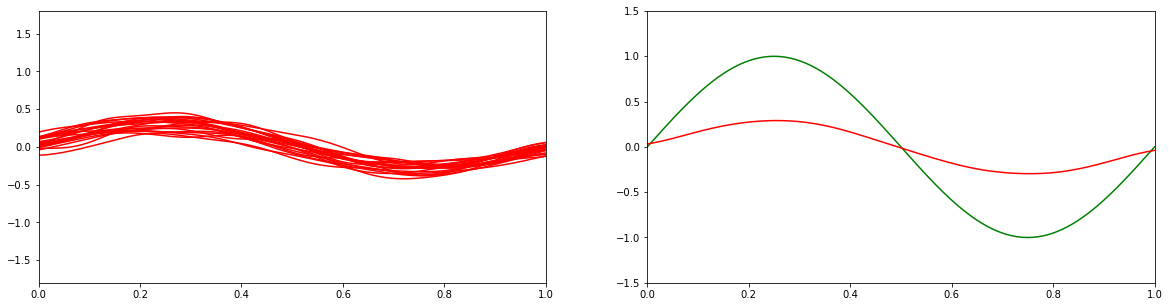

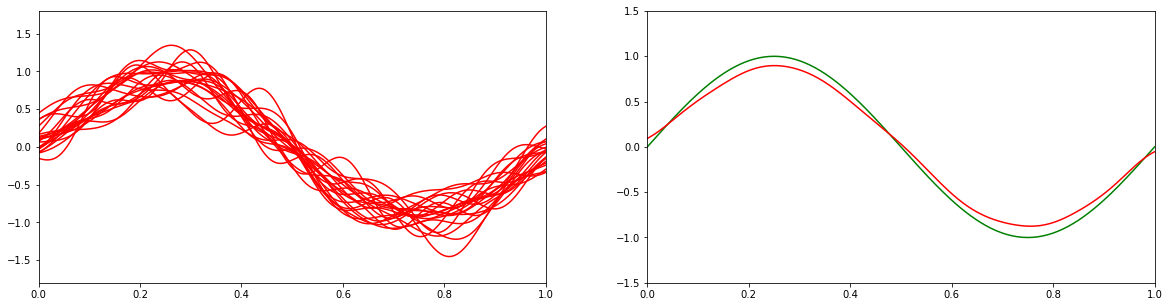

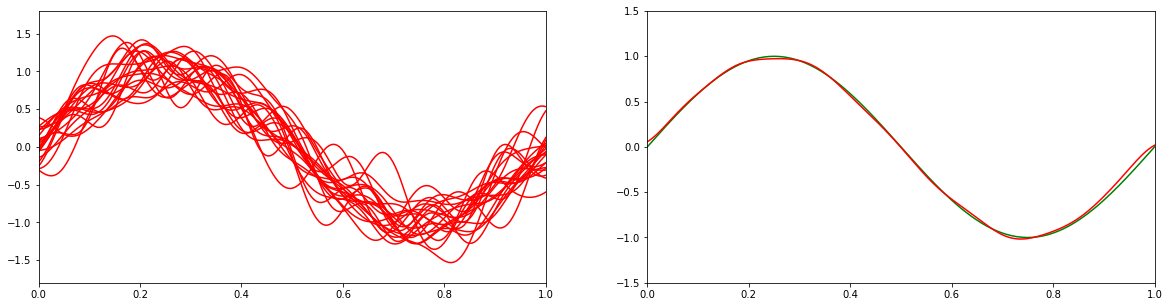

In [32]:
num_basis = 24
mu_j = np.linspace(0, 1, num_basis) # Mean of Gaussian basis functions
var = (1/num_basis) ** 2 # Variance of Gaussian basis functions
feature = GaussianFeature(mu_j, var) # Define Gaussian Feature object
num_data_sets = 100 # Number of independent data sets to generate
x_test, y_test  = gen_synth_data(sinusoidal, 200, 0) # Test data set for evaluation 
                                                     # Ideal sine wave with no noise
phi_mat_test = feature.transform(x_test) # Gaussian basis functions corresponding to x_test    

ln_lmbda = [2.6, -0.31, -2.4]
for val in ln_lmbda:
    alpha = np.exp(val)
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.xlim([0, 1])
    plt.ylim([-1.8, 1.8])
    y_pred_list = []
    for dset in range(num_data_sets):
        x_train, y_train = gen_synth_data(sinusoidal, 25, 0.3) # Generate training data set with 25 points
        phi_mat_train = feature.transform(x_train) # Gaussian basis functions corresponding to current training set
        model = Ridge(alpha = alpha) # Define ridge regression model 
        model.fit(phi_mat_train, y_train) # Fit model to current training set
        y_pred = model.predict(phi_mat_test) # Make predictions on test set based on current model fit
        y_pred_list.append(y_pred)
        if (dset <= 20):
            plt.plot(x_test, y_pred, color = 'red')
    
    y_pred_avg = np.asarray(y_pred_list).mean(axis = 0)
    plt.subplot(1, 2, 2)
    plt.xlim([0, 1])
    plt.ylim([-1.5, 1.5])    
    plt.plot(x_test, y_test, color = 'g')
    plt.plot(x_test, y_pred_avg, color = 'r')
    plt.show()